In [65]:
from torchvision import *
import torchvision as vision
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

In [66]:
# model = torch.nn.Sequential(*(list(model.children())[:-1]))
df = pd.read_csv('../datasets/processed/pokemon.csv')
ohe = OneHotEncoder()
ohe.fit(df[['type1']])
types = ohe.transform(df[['type1']]).toarray()
# chosen = [20, 100, 1, 5, 2]
df = df.query('dex  < 5')

In [67]:
# create a new model using custom encoder and decoder
class VIencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.vit_b_16(weights='IMAGENET1K_V1')
        self.decoder = torch.nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 150528),
            nn.Sigmoid(),
            )


    def forward(self, image, ptype):
        tensor = self.encoder(img)
        # tensor = torch.cat((tensor, ptype)).float()
        outputs = self.decoder(tensor)
        return outputs

In [68]:
# # create a new model using custom encoder and decoder
class VIencoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.vit_b_16(weights='IMAGENET1K_V1')
        self.middle1 = nn.Sequential( 
            nn.Linear(1000, 768))
        self.middle = nn.Sequential(
            nn.Conv2d(3, 5, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(5, 5, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.decoder = torch.nn.Sequential(
            nn.Linear(20, 150528),
            nn.Sigmoid(),
            )

    
    def forward(self, image, ptype):
        tensor = self.encoder(img)
        tensor = self.middle1(tensor)
        tensor = tensor.view(-1, 3, 16, 16)
        tensor = self.middle(tensor)
        tensor = tensor.flatten(1)
        outputs = self.decoder(tensor)
        return outputs

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# vie = VIencoder()
# vie = torch.load('pokemon_autoencoder.pt')
vie = VIencoder2()
vie.to(device)

cpu


VIencoder2(
  (encoder): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): La

In [70]:
# finetune model on pokemon dataset
epochs = 5000
learning_rate = 0.0000001
optimizer = torch.optim.Adam(vie.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [71]:
import torch.utils


class pokemondata(torch.utils.data.Dataset):
    def __init__(self, df, types):
        self.df = df
        self.types = types

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image'])
        img = img.convert('RGB')
        img = vision.transforms.Resize((224, 224))(img)
        img = vision.transforms.ToTensor()(img)
        img = img.float()
        img = img.to(device)
        ptype = torch.tensor(self.types[idx,:]).to(device)
        return img, ptype
    
dataloader = torch.utils.data.DataLoader(pokemondata(df, types), batch_size=1, shuffle=True)

In [74]:
torch.utils.data.DataLoader?

Init signature:
torch.utils.data.DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process load

In [72]:
# Training loop
for epoch in range(1000):
    losses = []
    for img, ptype in dataloader:
        optimizer.zero_grad()
        output = vie(img, ptype)
        img = img.flatten()
        loss = criterion(output.flatten(), img)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 20 == 0:
        torch.save(vie, 'pokemon_autoencoder2.pt')
        print(f'Epoch {epoch} Loss: {np.mean(losses)}')

Epoch 0 Loss: 0.14345907606184483
Epoch 20 Loss: 0.1429781001061201
Epoch 40 Loss: 0.14273822866380215


KeyboardInterrupt: 

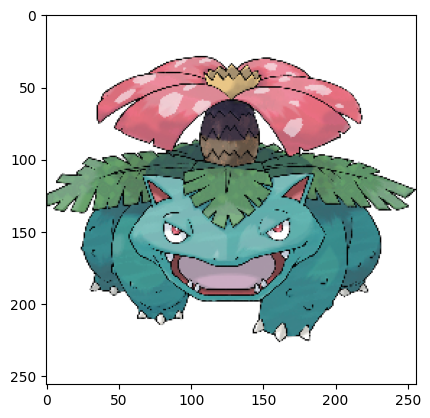

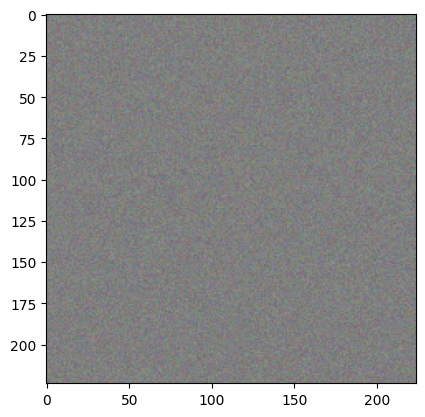

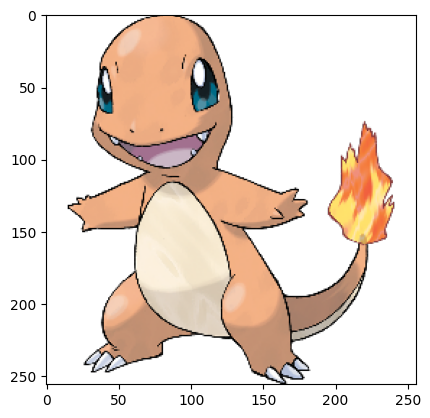

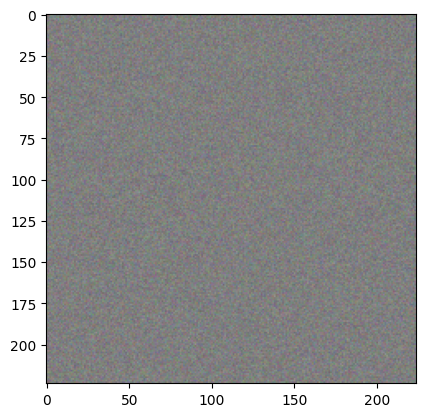

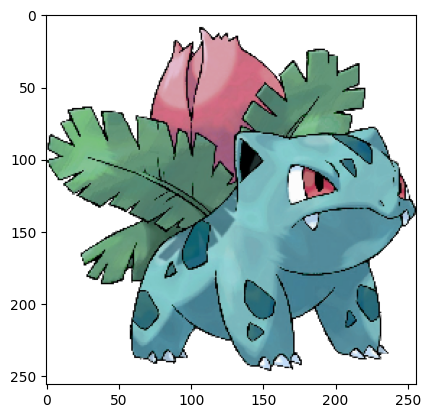

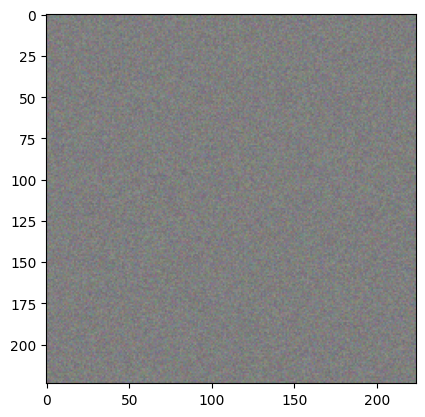

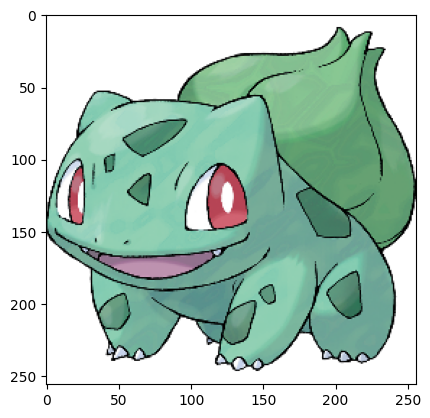

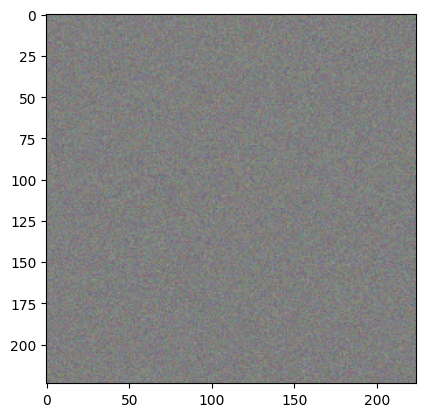

In [73]:
# df = pd.read_csv('../datasets/processed/pokemon.csv')
outputs = []
# show 5 reconstructed images
for i in df.sample(4).index:
    # image = Image.open(df['image'][i])
    img = Image.open(df['image'][i])
    ptype = torch.tensor(types[i, :]).float().to(device)
    img = img.convert('RGB')
    img = vision.transforms.Resize((224, 224))(img)
    img = vision.transforms.ToTensor()(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    output = vie(img, ptype)
    output = output.view(3, 224, 224)
    output = vision.transforms.ToPILImage()(output)
    outputs.append(output)
    plt.figure(i+10)
    plt.imshow(Image.open(df['image'][i]))
    plt.show()
    plt.figure(i+20)
    plt.imshow(output)
    plt.show()